In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import matplotlib.pyplot as plt
import numpy as np
import time
from torch.optim.lr_scheduler import StepLR, LambdaLR
import sympy as sp

In [2]:
device = torch.device("cuda:3" if torch.cuda.is_available() else "cpu")

In [46]:
class Multi_Func(nn.Module):
    def __init__(self, functions, num_params, symbols, x_data, input_channels, device):
        super().__init__()
        self.device = device
        self.functions = functions
        self.x_data = x_data.to(self.device)
        self.input_channels = input_channels
        self.num_params = num_params
        self.max_params = max(num_params)
        self.total_params = sum(self.num_params)
        self.symbols = symbols

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.input_channels, out_channels=8, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8, out_channels=6, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(64)
        )

        self.hidden_xfc = nn.Sequential(
            nn.Linear(256, 64),
            nn.SELU(),
            nn.Linear(64, 32),
            nn.SELU(),
            nn.Linear(32, 20),
            nn.SELU(),
        )

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4, out_channels=4, kernel_size=5),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(16),
            nn.Conv1d(in_channels=4, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(8),
            nn.Conv1d(in_channels=2, out_channels=2, kernel_size=3),
            nn.SELU(),
            nn.AdaptiveAvgPool1d(4),
        )

        self.flatten_layer = nn.Flatten()

        self.hidden_embedding = nn.Sequential(
            nn.Linear(28, 128),
            nn.SELU(),
            nn.Linear(128, 64),
            nn.SELU(),
            nn.Linear(64, self.total_params),
        )

    def evaluate(self, params, index):
        symbols = self.symbols[index]
        formula = self.functions[index]
        x = self.x_data
        var_values = {str(symbols[j]): params[:, j] for j in range(len(symbols)-1)}
        eval_func = sp.lambdify(symbols, formula, modules="numpy")
        var_values[str(symbols[-1])] = x.unsqueeze(1)
        results = eval_func(**var_values)
        results = torch.nan_to_num(results, 0)
        return results.swapaxes(0,1)

    def forward(self, inputs):
        outs = torch.swapaxes(inputs.unsqueeze(2), 1, 2).to(self.device)
        outs = self.hidden_x1(outs)
        xfc = torch.reshape(outs, (-1, 256))
        xfc = self.hidden_xfc(xfc)

        outs = torch.reshape(outs, (-1, 2, 128))
        outs = self.hidden_x2(outs)
        cnn_flat = self.flatten_layer(outs)
        encoded = torch.cat((cnn_flat, xfc), 1)
        embedding = self.hidden_embedding(encoded)

        #loss_func = nn.MSELoss()
        start_index = 0
        losses = []
        outputs = []
        all_params = []
        
        for f in range(len(self.functions)):
            params = embedding[:, start_index:start_index+self.num_params[f]]
            all_params.append(F.pad(params, (0, self.max_params-self.num_params[f])))
            output = self.evaluate(params, f).to(self.device)
            outputs.append(output)
            loss = torch.mean(((inputs - output) ** 2), dim=1)
            losses.append(loss)
            start_index += self.num_params[f]        
        stacked_losses = torch.stack(losses).to(self.device)
        stacked_preds = torch.stack(outputs).to(self.device)
        best_loss, best_indexes = torch.min(stacked_losses, dim=0)
        best_out = stacked_preds[best_indexes, -1]
        best_func = [self.functions[idx] for idx in best_indexes]
        best_params = []
        for index, value in enumerate(best_indexes):
            best_params.append(all_params[value][index])
        best_indexes = torch.tensor(best_indexes, dtype=torch.float32, requires_grad=True)
        return best_out, best_loss, best_func, best_indexes, torch.stack(best_params), outputs, losses, all_params

In [4]:
hold1 = torch.load('hold_data1.pth')
hold2 = torch.load('hold_data2.pth')
hold3 = torch.load('hold_data3.pth')
#hold4 = torch.load('hold_data4.pth')
#hold5 = torch.load('hold_data5.pth')

x_values = hold1['x_values'].to(device)
y_values = hold1['y_values'].to(device)
#derivatives = torch.cat((hold4['derivatives1'],hold4['derivatives2'])).to(device)
functions = hold2['formulas']
symbols = hold2['symbols']
function_labels = hold2['function_labels'].to(device)
params = hold3['param_values'].to(device)
num_params = hold3['num_params'].to(device)
full_params = hold3['full_params'].to(device)

/tmp/ipykernel_1137582/764187205.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  hold1 = torch.load('hold_data1.pth')
/tmp/ipykernel_1137582/764187205.py:2: FutureWarnin

In [5]:
print(f"x_values: {x_values.shape}")
print(f"y_values: {y_values.shape}")
#print(f"derivatives: {derivatives.shape}")
#print(f"hessians: {hessians.shape}")
print(f"param_values: {params.shape}")
print(f"formulas: {len(functions)}")
print(f"symbols: {len(symbols)}")
print(f"num_params: {num_params.shape}")
print(f"function_labels: {function_labels.shape}")
print(f"full_params: {full_params.shape}")

x_values: torch.Size([100])
y_values: torch.Size([100000, 100])
param_values: torch.Size([100000, 5])
formulas: 10
symbols: 10
num_params: torch.Size([10])
function_labels: torch.Size([100000])
full_params: torch.Size([100000, 50])


In [6]:
class TripleDataset(Dataset):
    def __init__(self, data1, data2, data3):
        self.data1 = data1
        self.data2 = data2
        self.data3 = data3
        
    def __len__(self):
        return len(self.data1)
    
    def __getitem__(self, index):
        return self.data1[index], self.data2[index], self.data3[index]

In [15]:
dataset = TripleDataset(y_values[0:2000, :], params[0:2000, :], function_labels[0:2000])
dataloader = DataLoader(dataset, batch_size=1000, shuffle=True)

In [49]:
model = Multi_Func(functions[0:2], num_params, symbols, x_values, 1, device).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.01)
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)
total_epochs = 100

def loss_func(output_y, target_y, output_params, target_params, output_function, target_function, lam):
    y_loss = torch.mean((output_y - target_y) ** 2)
    params_loss = torch.mean((output_params - target_params) ** 2)
    function_loss = torch.mean((output_function - target_function) ** 2)
    return function_loss
    #return y_loss*(1-lam) + params_loss*lam

def lambda_rule(epoch):
    start_lambda = 1*100
    end_lambda = 0
    return start_lambda - (start_lambda - end_lambda) * min(epoch / total_epochs, 1.0)

lambda_scheduler = LambdaLR(optimizer, lr_lambda=lambda_rule)

In [56]:
model.train()
for epoch in range(total_epochs):
    start_time = time.time()
    train_loss = 0.0
    total_num = 0
    optimizer.zero_grad()
    for inputs, true_params, true_func in dataloader:
        inputs = inputs.to(device)
        true_params = true_params.to(device)
        true_func = true_func.to(device)
        best_out,_,best_func,best_index,best_params,_,_,_= model(inputs)
        lam_val = lambda_scheduler.get_last_lr()[0]
        loss = loss_func(best_out, inputs, best_params, true_params, best_index.float(), true_func.float(), lam_val)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * best_out.shape[0]
        total_num += best_out.shape[0]
    scheduler.step()
    lambda_scheduler.step()
    train_loss /= total_num
    print(f"epoch : {epoch}/{total_epochs}, loss = {train_loss:.8f}")
    print(f"--- {time.time() - start_time} seconds ---")

/tmp/ipykernel_1137582/182172253.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_indexes = torch.tensor(best_indexes, dtype=torch.float32, requires_grad=True)


epoch : 0/100, loss = 0.45950003
--- 0.08665847778320312 seconds ---
epoch : 1/100, loss = 0.45950001
--- 0.06239628791809082 seconds ---
epoch : 2/100, loss = 0.45950001
--- 0.19760894775390625 seconds ---
epoch : 3/100, loss = 0.45950001
--- 0.06339168548583984 seconds ---
epoch : 4/100, loss = 0.45950001
--- 0.06435990333557129 seconds ---
epoch : 5/100, loss = 0.45950003
--- 0.06240487098693848 seconds ---
epoch : 6/100, loss = 0.45950003
--- 0.06278228759765625 seconds ---
epoch : 7/100, loss = 0.45950003
--- 0.06236147880554199 seconds ---
epoch : 8/100, loss = 0.45950001
--- 0.06216096878051758 seconds ---
epoch : 9/100, loss = 0.45950001
--- 0.06199002265930176 seconds ---
epoch : 10/100, loss = 0.45950003
--- 0.0624842643737793 seconds ---
epoch : 11/100, loss = 0.45950003
--- 0.062339067459106445 seconds ---
epoch : 12/100, loss = 0.45950001
--- 0.0644524097442627 seconds ---
epoch : 13/100, loss = 0.45950003
--- 0.06281828880310059 seconds ---
epoch : 14/100, loss = 0.459500

best_func: a*x**2 + b*x + c
best_loss: 0.5441901683807373


/tmp/ipykernel_1137582/182172253.py:112: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  best_indexes = torch.tensor(best_indexes, dtype=torch.float32, requires_grad=True)


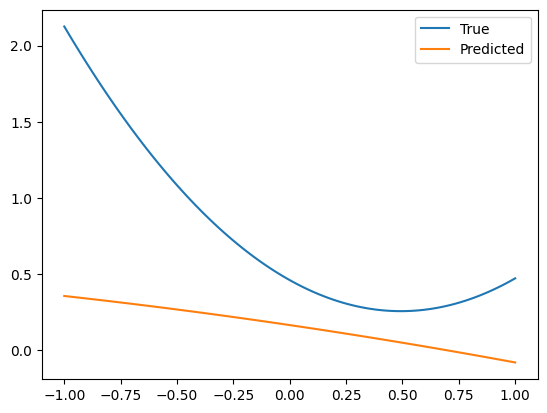

In [55]:
model.eval()
ran = np.random.randint(0, 100)
best_out, best_loss, best_func, best_indexes, best_params, stacked_preds, stacked_losses, all_params = model(y_values[0:2000])
print(f"best_func: {best_func[ran]}")
print(f"best_loss: {best_loss[ran]}")
plt.plot(x_values.detach().cpu().numpy(), y_values[ran].detach().cpu().numpy(), label='True')
plt.plot(x_values.detach().cpu().numpy(), best_out[ran].detach().cpu().numpy(), label='Predicted')
plt.legend()